In [71]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [73]:
df_train = pd.read_csv('/content/4. loan_data_train.csv')

df_train.head()

,PROSPECTID,Total_TL,Tot_Closed_TL,Tot_Active_TL,Total_TL_opened_L6M,Tot_TL_closed_L6M,pct_tl_open_L6M,pct_tl_closed_L6M,pct_active_tl,pct_closed_tl,...,pct_PL_enq_L6m_of_L12m,pct_CC_enq_L6m_of_L12m,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,HL_Flag,GL_Flag,last_prod_enq2,first_prod_enq2,Credit_Score,Approved_Flag
0,46228,2,1,1,0,0,0.000,0.00,0.50,0.50,...,0.0,0.0,0.0,0.0,1,0,PL,others,710,P1
1,4824,4,2,2,1,1,0.250,0.25,0.50,0.50,...,0.0,0.0,0.0,0.0,0,0,ConsumerLoan,ConsumerLoan,706,P1
2,4011,12,9,3,2,0,0.167,0.00,0.25,0.75,...,0.0,0.0,0.0,0.0,1,0,others,AL,690,P2
3,32105,5,0,5,0,0,0.000,0.00,1.00,0.00,...,0.0,0.0,0.0,0.0,0,0,ConsumerLoan,others,658,P4
4,24500,1,0,1,0,0,0.000,0.00,1.00,0.00,...,0.0,0.0,0.0,0.0,0,0,AL,AL,690,P2


In [74]:
X_train = df_train.iloc[:,1:-1]

y_train = df_train.iloc[:,-1]

In [75]:
print(X_train.shape)
print(y_train.shape)

(31549, 74)
(31549,)


In [76]:
label_encoder = LabelEncoder().fit(y_train)

y_train_trf = label_encoder.transform(y_train)

# 1.Model Building & Evaluation

In [77]:
categorical_cols = X_train.select_dtypes(include = 'object').columns.tolist()

trf_applied = [('ohe_encoding', OneHotEncoder(sparse_output = False, dtype = int, handle_unknown = 'ignore'), categorical_cols) ]

preprocessing = ColumnTransformer(transformers = trf_applied, remainder = 'passthrough')


## a. Using GridSearchCV to tune the entire pipeline

In [78]:
skf = StratifiedKFold(n_splits=5, shuffle = True)

gbc = GradientBoostingClassifier(n_estimators = 10)

pipe = Pipeline(steps = [
    ('One Hot Encoding', preprocessing),
    ('gb_feature_selection', SelectFromModel(estimator = gbc, threshold = 0)),
    ('One_way_ANOVA_feature_selection', SelectKBest(score_func = f_classif)),
    ('classifier', GradientBoostingClassifier(n_estimators = 20))
])

params= {'gb_feature_selection__max_features': ['sqrt', 'log2', 10, 20, 40, 50],
         'One_way_ANOVA_feature_selection__k': [10, 20, 31, 40]}


grid_search = GridSearchCV(estimator = pipe, param_grid = params, scoring = 'accuracy', cv = skf, n_jobs = -1, refit = True)

grid_search.fit(X_train, y_train_trf)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('One Hot Encoding',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe_encoding',
                                                                         OneHotEncoder(dtype=<class 'int'>,
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['MARITALSTATUS',
                                                                          'EDUCATION',
                                                                          'GENDER',
                                                                          'last_prod_enq2',
                                                                          'first_prod_enq2'])])),
                                       ('g...
                                        SelectFromModel(estimator=GradientBoostingClassifier(n_estimators=10),
                                                        threshold=0)),
                                       ('One_way_ANOVA_feature_selection',
                                        SelectKBest()),
                                       ('classifier',
                                        GradientBoostingClassifier(n_estimators=20))]),
             n_jobs=-1,
             param_grid={'One_way_ANOVA_feature_selection__k': [10, 20, 31, 40],
                         'gb_feature_selection__max_features': ['sqrt', 'log2',
                                                                10, 20, 40,
                                                                50]},
             scoring='accuracy')

In [79]:
print('Best Hyper-parameters:', grid_search.best_params_)

print('Best score:', grid_search.best_score_)

Best Hyper-parameters: {'One_way_ANOVA_feature_selection__k': 10, 'gb_feature_selection__max_features': 40}
Best score: 0.9951821097272806


In [80]:
model = grid_search.estimator

## b.Fitting Model Pipeline

In [81]:
model.fit(X_train, y_train_trf)

Pipeline(steps=[('One Hot Encoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_encoding',
                                                  OneHotEncoder(dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['MARITALSTATUS', 'EDUCATION',
                                                   'GENDER', 'last_prod_enq2',
                                                   'first_prod_enq2'])])),
                ('gb_feature_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(n_estimators=10),
                                 threshold=0)),
                ('One_way_ANOVA_feature_selection', SelectKBest()),
                ('classifier', GradientBoostingClassifier(n_estimators=20))])

## c.Exporting Model Pipeline

In [82]:
import pickle

pickle.dump(model, open('credit_risk_model.pkl','wb'))

pickle.dump(label_encoder, open('label_encoder.pkl','wb'))

## d. Loading Model Pipeline

In [83]:
model  = pickle.load(open('/content/credit_risk_model.pkl','rb'))

label_encoder = pickle.load(open('/content/label_encoder.pkl', 'rb'))

# 2.Model Performance on Unseen data

In [84]:
df_test = pd.read_csv('/content/5. loan_data_test.csv')

X_test = df_test.iloc[:,1:-1]
y_test = df_test.iloc[:,-1]

y_test_trf = label_encoder.transform(y_test)

In [85]:
X_test.shape

(10517, 74)

In [86]:
skf = StratifiedKFold(n_splits = 10, shuffle = True)

scoring_metrics = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']

results_test = cross_validate(model, X_test, y_test, cv = skf, scoring = scoring_metrics, n_jobs=-1)

In [87]:
results_test

{'fit_time': array([5.38222218, 4.90979457, 3.8779304 , 3.85392046, 3.848948  ,
        3.79246259, 4.98443508, 5.01083422, 4.17984915, 3.92174602]),
 'score_time': array([0.05352211, 0.13253641, 0.04934883, 0.05137873, 0.04953074,
        0.04857278, 0.06532311, 0.13827729, 0.05254173, 0.03002501]),
 'test_accuracy': array([0.99239544, 0.99429658, 0.99714829, 0.99524715, 0.99429658,
        0.99429658, 0.99809886, 0.99524263, 0.9961941 , 0.99809705]),
 'test_f1_weighted': array([0.99236993, 0.99428443, 0.99714688, 0.99523418, 0.99427745,
        0.99427745, 0.99809886, 0.99523497, 0.99618573, 0.99809506]),
 'test_precision_weighted': array([0.99258576, 0.99437985, 0.99715223, 0.99539031, 0.99450149,
        0.99450149, 0.99809886, 0.99528826, 0.99628637, 0.9981204 ]),
 'test_recall_weighted': array([0.99239544, 0.99429658, 0.99714829, 0.99524715, 0.99429658,
        0.99429658, 0.99809886, 0.99524263, 0.9961941 , 0.99809705])}

In [88]:
results_test  = pd.DataFrame(results_test).iloc[:,2:].mean(axis=0).reset_index().rename(columns = {'index':'performance_metrics',0:'result'})

results_test


,performance_metrics,result
0,test_accuracy,0.995531
1,test_f1_weighted,0.995520
2,test_precision_weighted,0.995631
3,test_recall_weighted,0.995531


In [89]:
label_encoder.inverse_transform(model.predict(X_test))

array(['P1', 'P4', 'P2', ..., 'P4', 'P2', 'P2'], dtype=object)

In [90]:
accuracy_score(y_test_trf, model.predict(X_test))

0.9955310449748027

In [91]:
df_test.iloc[0].values

array([11299, 2, 1, 1, 0, 0, 0.0, 0.0, 0.5, 0.5, 1, 0, 0.5, 0.0, 0, 0, 0,
       1, 0, 0, 0, 0, 2, 1, 63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 204, 1, 0, 0, 'Married',
       '12TH', 54, 'M', 25000, 362, 0.0, 0.3, 0, 0, 0.0, 0.0, 0.0, 0.0, 0,
       0, 'others', 'others', 713, 'P1'], dtype=object)

In [92]:
X_test.iloc[0].values

array([2, 1, 1, 0, 0, 0.0, 0.0, 0.5, 0.5, 1, 0, 0.5, 0.0, 0, 0, 0, 1, 0,
       0, 0, 0, 2, 1, 63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 204, 1, 0, 0, 'Married', '12TH',
       54, 'M', 25000, 362, 0.0, 0.3, 0, 0, 0.0, 0.0, 0.0, 0.0, 0, 0,
       'others', 'others', 713], dtype=object)

In [93]:
label_encoder.inverse_transform(model.predict(pd.DataFrame(X_test.iloc[0]).T))

array(['P1'], dtype=object)

In [94]:
df_test.iloc[1].values

array([42649, 9, 1, 8, 3, 1, 0.333, 0.111, 0.889, 0.111, 4, 1, 0.444,
       0.111, 0, 0, 7, 1, 0, 0, 1, 0, 9, 0, 38, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 65, 22, 6, 12, 29, 26, 29, 20, 55,
       38, 19, 'Single', 'POST-GRADUATE', 27, 'M', 37000, 30, 0.75, 0.813,
       1, 1, 0.897, 0.5, 0.897, 0.273, 0, 0, 'ConsumerLoan', 'CC', 595,
       'P4'], dtype=object)

In [95]:
X_test.iloc[1].values

array([9, 1, 8, 3, 1, 0.333, 0.111, 0.889, 0.111, 4, 1, 0.444, 0.111, 0,
       0, 7, 1, 0, 0, 1, 0, 9, 0, 38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 65, 22, 6, 12, 29, 26, 29, 20, 55, 38, 19,
       'Single', 'POST-GRADUATE', 27, 'M', 37000, 30, 0.75, 0.813, 1, 1,
       0.897, 0.5, 0.897, 0.273, 0, 0, 'ConsumerLoan', 'CC', 595],
      dtype=object)

In [96]:
label_encoder.inverse_transform(model.predict(pd.DataFrame(X_test.iloc[1]).T))

array(['P4'], dtype=object)

# 3.Bias - Variance Decomposition

In [97]:
pipeline_xtend = Pipeline(steps = [
    ('One Hot Encoding', preprocessing),
    ('gb_feature_selection', SelectFromModel(estimator = gbc, threshold = 0, max_features = 20) ),
    ('One_way_ANOVA_feature_selection', SelectKBest(score_func = f_classif, k = 20 ) )
])

In [98]:
pipeline_xtend.fit(X_train, y_train_trf)

Pipeline(steps=[('One Hot Encoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_encoding',
                                                  OneHotEncoder(dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['MARITALSTATUS', 'EDUCATION',
                                                   'GENDER', 'last_prod_enq2',
                                                   'first_prod_enq2'])])),
                ('gb_feature_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(n_estimators=10),
                                 max_features=20, threshold=0)),
                ('One_way_ANOVA_feature_selection', SelectKBest(k=20))])

In [99]:
cols = pipeline_xtend.get_feature_names_out().tolist()

In [100]:
pipeline_xtend.transform(X_train).shape

(31549, 20)

In [101]:
X_train_xtend = pd.DataFrame(data = pipeline_xtend.transform(X_train), columns = cols )

X_test_xtend =  pd.DataFrame(data = pipeline_xtend.transform(X_test),  columns = cols)

In [105]:
import mlxtend

from mlxtend.evaluate import bias_variance_decomp

gbc = GradientBoostingClassifier(n_estimators = 20)

avg_bias, avg_variance, avg_error = bias_variance_decomp(estimator = gbc, X_train = X_train_xtend.values, y_train = y_train_trf,
                                                       X_test = X_test_xtend.values, y_test = y_test_trf, loss = '0-1_loss',
                                                       num_rounds = 100, random_seed=1)


In [106]:
print(f'Average Error: {avg_error:.5f}')
print(f'Average Bias: {avg_bias:.5f}')
print(f'Average Variance: {avg_variance:.5f}')

Average Error: 0.00015
Average Bias: 0.00455
Average Variance: 0.00447


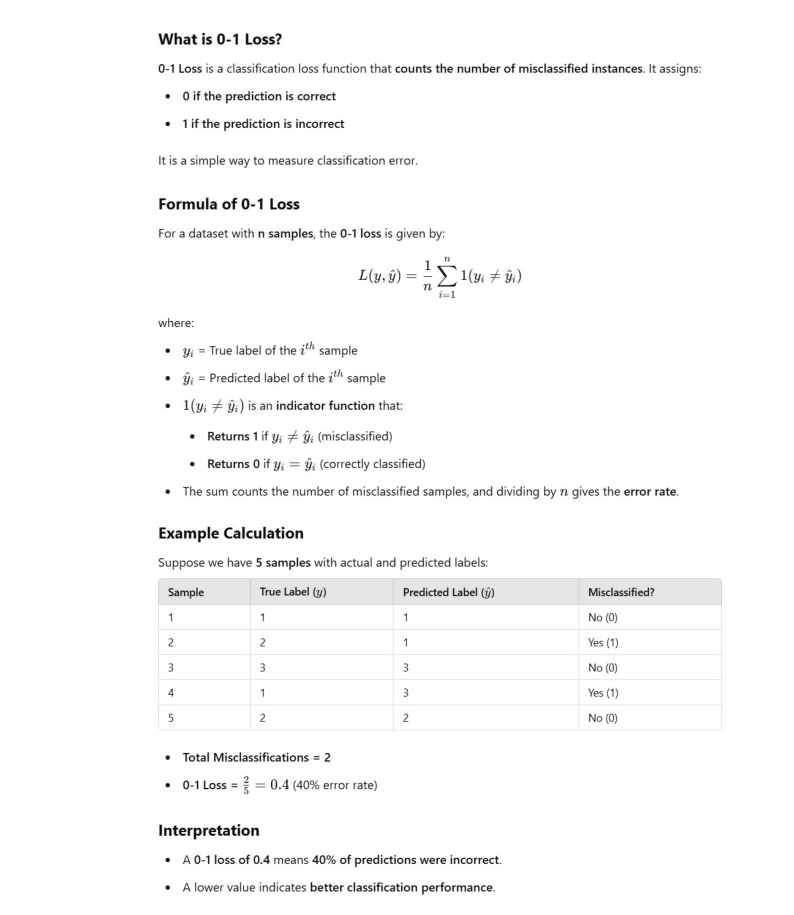

In [107]:
import cv2
import matplotlib.pyplot as plt

# Load image
image_path = "/content/0-1 loss.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Set figure size
plt.figure(figsize=(10, 12))  # Increase figure size
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()